In [114]:
from pydrake.examples.acrobot import (AcrobotGeometry, AcrobotInput,
                                      AcrobotPlant, AcrobotState, AcrobotParams)
from pydrake.all import Linearize, LinearQuadraticRegulator, SymbolicVectorSystem, Variable, Saturation, \
WrapToSystem, Simulator

from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

from IPython.display import SVG, display
import pydot
import numpy as np
import math
import control

import matplotlib.pyplot as plt

In [2]:
p = AcrobotParams()

In [4]:
m1 = p.m1()
m2 = p.m2()
l1 = p.l1()
lc1 = p.lc1()
lc2 = p.lc2()
Ic1 = p.Ic1()
Ic2 = p.Ic2()
b1 = p.b1()
b2 = p.b2()
gravity = p.gravity()

In [5]:
I1 = Ic1 + m1*lc1**2
I2 = Ic2 + m2*lc2**2

In [8]:
# enter the linearized matrices
E = np.array([[1, 0, 0, 0], \
              [0, 1, 0, 0], \
              [0, 0, I1 + I2 + m2*l1**2 + 2*m2*l1*lc2, I2 + m2*l1*lc2], \
              [0, 0, I2 + m2*l1*lc2, I2]])

A = np.array([[0, 0, -1, 0], \
              [0, 0, 0, -1], \
              [-m1*gravity*lc1+m2*gravity*(-l1-lc2), -m2*gravity*lc2, b1, 0], \
              [-m2*gravity*lc2, -m2*gravity*lc2, 0, b2]])

B = np.array([[0], [0], [0], [-1]])

A = -A
B = -B

In [11]:
Q = np.diag([10, 10, 1, 1])
R = [1]

X, L, K = control.care(A, B, Q, R, E=E)

In [12]:
K

array([[-278.44223126, -112.29125985, -119.72457377,  -56.82824017]])

In [32]:
A_cloop = A-B@K
Q_lyap = np.eye(4)

P = control.lyap(A_cloop.T, Q_lyap, E = E.T)

np.linalg.eigvals(P)

array([2.10360973e+03, 2.05043095e+00, 9.98528759e-01, 7.65896243e-03])

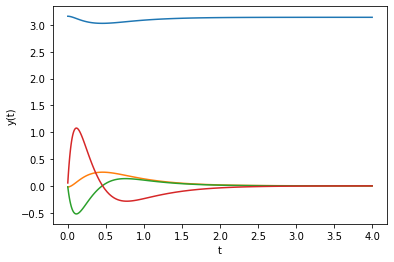

In [115]:
# try out the controller
t1 = Variable("t1")
t2 = Variable("t2")
td1 = Variable("td1")
td2 = Variable("td2")
garbage = Variable("garbage")

x = np.hstack([t1, t2, td1, td2])
u = -K@(x  - UprightState().CopyToVector())

own_controller = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=u)

def acrobot_balancing_example():

    builder = DiagramBuilder()
    acrobot = builder.AddSystem(AcrobotPlant())

    saturation = builder.AddSystem(Saturation(min_value=[-10], max_value=[10]))
    builder.Connect(saturation.get_output_port(0), acrobot.get_input_port(0))
    wrapangles = WrapToSystem(4)
    wrapangles.set_interval(0, 0, 2. * np.pi)
    wrapangles.set_interval(1, -np.pi, np.pi)
    wrapto = builder.AddSystem(wrapangles)
    builder.Connect(acrobot.get_output_port(0), wrapto.get_input_port(0))
    controller = builder.AddSystem(own_controller)
    builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))
    
    logger = LogVectorOutput(wrapto.get_output_port(0), builder)

#     # Setup visualization
#     scene_graph = builder.AddSystem(SceneGraph())
#     AcrobotGeometry.AddToBuilder(builder, acrobot.get_output_port(0), scene_graph)
#     meshcat.Delete()
#     meshcat.Set2dRenderMode(xmin=-4, xmax=4, ymin=-4, ymax=4)
#     MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()
    
#     simulator = Simulator(diagram)
#     context = simulator.get_mutable_context()
#     print(context)
#     display(SVG(pydot.graph_from_dot_data(
#     diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # Simulate
    simulator.set_target_realtime_rate(0.0)
    duration = 4.0 
    for i in range(1):
        context.SetTime(0.)
        context.SetContinuousState(np.append(UprightState().CopyToVector(), 0) +
                                0.05 * np.random.randn(5,))
        simulator.Initialize()
        simulator.AdvanceTo(duration)
        
        log = logger.FindLog(context)
        plt.figure()
        plt.plot(log.sample_times(), log.data().transpose())
        plt.xlabel('t')
        plt.ylabel('y(t)');

acrobot_balancing_example()

In [103]:
UprightState().CopyToVector() + 0.05 * np.random.randn(4,)

array([ 3.09582565,  0.00313207, -0.08825696,  0.07258637])

In [15]:
ACRO = AcrobotPlant()

In [93]:
def UprightState():
    state = AcrobotState()
    state.set_theta1(np.pi)
    state.set_theta2(0.)
    state.set_theta1dot(0.)
    state.set_theta2dot(0.)
    return state

context = ACRO.CreateDefaultContext()
input = AcrobotInput()
input.set_tau(0)
ACRO.get_input_port(0).FixValue(context, input)

context.get_mutable_continuous_state_vector().SetFromVector(UprightState().CopyToVector())

In [57]:
linearized_acro = Linearize(ACRO, context)

LQR = LinearQuadraticRegulator(linearized_acro.A(), linearized_acro.B(), Q, R)

In [58]:
LQR

(array([[-278.44223126, -112.29125985, -119.72457377,  -56.82824017]]),
 array([[16620.60660543,  7470.1873401 ,  7240.12368147,  3571.58116271],
        [ 7470.1873401 ,  3374.43640793,  3256.40272521,  1608.54161654],
        [ 7240.12368147,  3256.40272521,  3154.73036214,  1556.50607291],
        [ 3571.58116271,  1608.54161654,  1556.50607291,   768.33308414]]))

In [45]:
c = ACRO.get_mutable_state(context)

In [49]:
d = ACRO.get_state(context)

In [52]:
type(d)

pydrake.examples.acrobot.AcrobotState

In [53]:
type(c)

pydrake.examples.acrobot.AcrobotState